In [6]:
import pandas as pd
import networkx as nx
from sklearn.cluster import Birch
import numpy as np
from networkx.algorithms.community.centrality import girvan_newman
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans, DBSCAN, Birch
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
import igraph as ig
import community
from graph_generating_script import *
from sklearn.model_selection import ParameterGrid
import networkx as nx


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

def find_best_num_clusters(data, max_clusters=10):
    best_score = -1
    best_num_clusters = 2  # Minimum number of clusters
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_num_clusters = n_clusters
    
    return best_num_clusters


from sklearn.cluster import AgglomerativeClustering, OPTICS


# get results from one model on one graph on one of the layouts
# returns : scores - list with ARI

def get_clusters_from_positions(posdf, best_num, true_labels):
    #agglomerative clustering
    scores = []
    # for i in range(k):
    model = AgglomerativeClustering(affinity='euclidean', n_clusters=best_num)
    model.fit(posdf)
    yhat = list(model.labels_)
    # scores[0] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))

    #DBscan
    model = OPTICS()
    model.fit(posdf)
    yhat= list(model.labels_)
    # scores[1] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))

    # kmeans
    model = KMeans(n_clusters=best_num, random_state=212)
    model.fit(posdf)
    yhat = list(model.predict(posdf))
    # scores[2] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))

    #GMM
    from sklearn.mixture import GaussianMixture
    #modeling
    model = GaussianMixture(n_components=best_num, random_state=212).fit(posdf)
    yhat = list(model.predict(posdf))
    # scores[3] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))

    #Birch
    model = Birch(n_clusters=best_num)
    model.fit(posdf)
    yhat = list(model.predict(posdf))
    # scores[4] += adjusted_rand_score(true_labels, yhat)
    scores.append(adjusted_rand_score(true_labels, yhat))


    return scores


def get_communities(G, true_labels):
    scores = []
    #separate tool to choose number of communities for girvan newman
    partition = community.best_partition(G)
    num_communities = len(set(partition.values()))
    print(f'community number {num_communities}')
    # print(f'Number for communities for Girvan Newman: {num_communities}')
    G1 = G.copy()
    
    while nx.number_connected_components(G1) < num_communities:
        edge_centrality = nx.edge_betweenness_centrality(G1)
        max_edge = max(edge_centrality, key=edge_centrality.get)
        G1.remove_edge(*max_edge)
    
    communities = list(nx.connected_components(G1))
    comms = []
    for com in communities:
        comms.append(list(com))
    list_comms = [None] * len(G.nodes)
    for i in range(len(comms)):
        com = comms[i]
        for node in com:
            list_comms[node] = i

    scores.append(adjusted_rand_score(true_labels, list_comms))
    # scores[5] += adjusted_rand_score(true_labels, list_comms)

    #Leiden
    # G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)
    # partition = G_ig.community_leiden(objective_function="modularity")
    # list_comms = [None] * len(G.nodes)
    # for i, com in enumerate(partition):
    #     for node in com:
    #         list_comms[node] = i
    G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)

    resolutions = np.linspace(0.1, 1.5, 10)  # Adjust the range as needed
    param_grid = {'resolution': resolutions}
    grid = ParameterGrid(param_grid)

    best_modularity = -np.inf
    best_partition = None
    for params in grid:
        partition = G_ig.community_leiden(objective_function="modularity", **params)
        modularity = G_ig.modularity(partition)
        if modularity > best_modularity:
            best_modularity = modularity
            best_partition = partition

    list_comms = [None] * len(G.nodes)
    for i, com in enumerate(best_partition):
        for node in com:
            list_comms[node] = i
    # scores[6] += adjusted_rand_score(true_labels, list_comms)
    scores.append(adjusted_rand_score(true_labels, list_comms))
    return scores

def add_scores(df, scores, layout_name='spring'):
    scores.insert(0, layout_name)
    data = df.to_dict('records')
    data.append(dict(zip(df.columns, scores)))
    df = pd.DataFrame(data)
    return df

# def scaling_igraph(layout):
#     coords = np.array(layout.coords)
#     min_coords = coords.min(axis=0)
#     max_coords = coords.max(axis=0)
#     scaled_coords = 2 * (coords - min_coords) / (max_coords - min_coords) - 1
#     posdf = pd.DataFrame(scaled_coords, columns=['X', 'Y'])
#     return posdf


# coducts ONE experiemnt for all (7) the layouts
# returns : df with ARI layouts and algoriths for ONE graph

def full_cluster_experiment(G, true_labels):
    # df = pd.DataFrame(columns=['layout','AgglomerativeClustering', 'OPTICS', 'KMeans', 'GMM', 'Birch', 'Girvan Newman', 'Leiden'])
    df = pd.DataFrame(columns=['layout','AgglomerativeClustering', 'OPTICS', 'KMeans', 'GMM', 'Birch'])

    #for every layout
    #kamada kawai
    pos = nx.kamada_kawai_layout(G)
    posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print("kamada")
    print(best_num)
    # print(f'Best number of clusters detected : {best_num}')
    scores = get_clusters_from_positions(posdf, best_num, true_labels)
    df = add_scores(df, scores, 'kamada_kawai')

    #spring layout
    pos = nx.spring_layout(G)
    posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print('spring')
    print(best_num)
    scores = get_clusters_from_positions(posdf, best_num, true_labels)
    df = add_scores(df, scores, 'spring')

    #algorithms from igraph
    G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)

    #davidson harel
    layout = G_ig.layout('davidson_harel')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print('davisdon harel')
    print(best_num)
    scores = get_clusters_from_positions( posdf, best_num, true_labels)
    df = add_scores(df, scores, 'davidson_harel')

    #drl
    layout = G_ig.layout('drl')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print('drl')
    print(best_num)
    scores = get_clusters_from_positions( posdf, best_num, true_labels)
    df = add_scores(df, scores, 'drl')

    # fruchterman reingold
    layout = G_ig.layout('fruchterman_reingold')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print('fruchterman')
    print(best_num)
    scores = get_clusters_from_positions( posdf, best_num, true_labels)
    df = add_scores(df, scores, 'fruchterman_reingold')

    #graphopt
    layout = G_ig.layout('graphopt')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print('graphopt')
    print(best_num)
    scores = get_clusters_from_positions( posdf, best_num, true_labels)
    df = add_scores(df, scores, 'graphopt')

    #lgl
    layout = G_ig.layout('lgl')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print('lgl')
    print(best_num)
    scores = get_clusters_from_positions( posdf, best_num, true_labels)
    df = add_scores(df, scores, 'lgl')

    #mds
    layout = G_ig.layout('mds')
    # posdf = scaling_igraph(layout)
    posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
    best_num = find_best_num_clusters(posdf)
    print('mds')
    print(best_num)
    scores = get_clusters_from_positions(posdf, best_num, true_labels)
    df = add_scores(df, scores, 'mds')

    return df

# generates k graphs and conducts FULL experiments on them
# it sums up ARIs and divides by k (average)
# returns : df


def steady_full_experiment(sizes, inside_prob, outside_prob, k=5, i_want_boxplot=False):
    (G, true_labels)= generate_G(sizes, inside_prob, outside_prob)
    asor = nx.numeric_assortativity_coefficient(G, "community")
    df = full_cluster_experiment(G, true_labels)
    df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: [x])
    #comms - list with two values
    comms = get_communities(G, true_labels)
    girvs = [comms[0]]
    leid = [comms[1]]
    #tu trzeba rozbic i osobno zrobic clustry, osobno community detection
    for i in range(1, k):
        print("DUPA")
        (G, true_labels)= generate_G(sizes, inside_prob, outside_prob)
        asor += nx.numeric_assortativity_coefficient(G, "community")
        tmp = full_cluster_experiment(G, true_labels)
        # df[df.columns[1:]] += tmp[tmp.columns[1:]]
        for column in df.columns[1:]:
            df[column] = df[column].combine(tmp[column], lambda x, y: x + [y])
            
        tmp = get_communities(G, true_labels)
        girvs.append(tmp[0])
        leid.append(tmp[1])
        # comms[0] += tmp[0]
        # comms[1] += tmp[1]


    # df[df.columns[1:]] /= k
    # df['Girvan-Newman'] = comms[0]/k
    df['Girvan-Newman'] = [girvs] * len(df)
    # df['Leiden'] = comms[1]/k
    df['Leiden'] = [leid] * len(df)

    print(f'Graphs assortavity coefficient : {asor/k}')
    if i_want_boxplot==False:
        df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: sum(x) / k)

    return df
    
    
def generate_G(sizes, inside_prob, outside_prob):
    probs = np.eye(len(sizes)) * inside_prob

    # Set the off-diagonal elements to the desired value (0.01)
    probs[probs == 0] = outside_prob
    true_labels=[]
    i=0
    for size in sizes:
        true_labels += ([i]*size)
        i += 1
    G = nx.stochastic_block_model(sizes, probs, seed=random.randint(0, 200))
    for node, community in zip(G.nodes(), true_labels):
        G.nodes[node]['community'] = community
        
    return (G, true_labels)

In [30]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
        refDisps = np.zeros(nrefs)
        for i in range(nrefs):
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
        km = KMeans(k)
        km.fit(data)
        origDisp = km.inertia_
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        gaps[gap_index] = gap
        
        resultsdf.loc[len(resultsdf)] = [k, gap]
        
    return (gaps.argmax() + 1, resultsdf)


In [35]:
(G, true_labels) = generate_G([10, 5, 10, 5, 10], .7, .03)
pos = nx.kamada_kawai_layout(G)
posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
nx.numeric_assortativity_coefficient(G, "community")

0.8219180833896895

Text(0.5, 1.0, 'Gap Statistic vs. K')

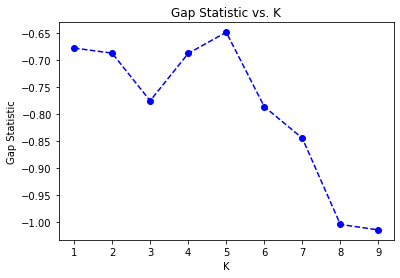

In [34]:
score_g, df = optimalK(posdf.to_numpy(), nrefs=10, maxClusters=10)

plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Gap Statistic')
plt.title('Gap Statistic vs. K')

In [37]:
# df = pd.DataFrame(columns=['layout','AgglomerativeClustering', 'OPTICS', 'KMeans', 'GMM', 'Birch', 'Girvan Newman', 'Leiden'])
df = pd.DataFrame(columns=['layout','AgglomerativeClustering', 'OPTICS', 'KMeans', 'GMM', 'Birch'])

#for every layout
#kamada kawai
pos = nx.kamada_kawai_layout(G)
posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
best_num, _ = optimalK(posdf.to_numpy(), nrefs=10, maxClusters=10)
print("kamada")
print(best_num)
# print(f'Best number of clusters detected : {best_num}')
scores = get_clusters_from_positions(posdf, best_num, true_labels)
df = add_scores(df, scores, 'kamada_kawai')

#spring layout
pos = nx.spring_layout(G)
posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
best_num, _ = optimalK(posdf.to_numpy(), nrefs=10, maxClusters=10)
print('spring')
print(best_num)
scores = get_clusters_from_positions(posdf, best_num, true_labels)
df = add_scores(df, scores, 'spring')

#algorithms from igraph
G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)

#davidson harel
layout = G_ig.layout('davidson_harel')
# posdf = scaling_igraph(layout)
posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
best_num, _ = optimalK(posdf.to_numpy(), nrefs=10, maxClusters=10)
print('davisdon harel')
print(best_num)
scores = get_clusters_from_positions( posdf, best_num, true_labels)
df = add_scores(df, scores, 'davidson_harel')

#drl
layout = G_ig.layout('drl')
# posdf = scaling_igraph(layout)
posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
best_num, _ = optimalK(posdf.to_numpy(), nrefs=10, maxClusters=10)
print('drl')
print(best_num)
scores = get_clusters_from_positions( posdf, best_num, true_labels)
df = add_scores(df, scores, 'drl')

# fruchterman reingold
layout = G_ig.layout('fruchterman_reingold')
# posdf = scaling_igraph(layout)
posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
best_num, _ = optimalK(posdf.to_numpy(), nrefs=10, maxClusters=10)
print('fruchterman')
print(best_num)
scores = get_clusters_from_positions( posdf, best_num, true_labels)
df = add_scores(df, scores, 'fruchterman_reingold')

#graphopt
layout = G_ig.layout('graphopt')
# posdf = scaling_igraph(layout)
posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
best_num, _ = optimalK(posdf.to_numpy(), nrefs=10, maxClusters=10)
print('graphopt')
print(best_num)
scores = get_clusters_from_positions( posdf, best_num, true_labels)
df = add_scores(df, scores, 'graphopt')

#lgl
layout = G_ig.layout('lgl')
# posdf = scaling_igraph(layout)
posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
best_num, _ = optimalK(posdf.to_numpy(), nrefs=10, maxClusters=10)
print('lgl')
print(best_num)
scores = get_clusters_from_positions( posdf, best_num, true_labels)
df = add_scores(df, scores, 'lgl')

#mds
layout = G_ig.layout('mds')
# posdf = scaling_igraph(layout)
posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])
best_num, _ = optimalK(posdf.to_numpy(), nrefs=10, maxClusters=10)
print('mds')
print(best_num)
scores = get_clusters_from_positions(posdf, best_num, true_labels)
df = add_scores(df, scores, 'mds')

kamada
5
spring
5
davisdon harel
3
drl
2
fruchterman
5
graphopt
5
lgl
9
mds
5


In [29]:
score_g

2

In [36]:
full_cluster_experiment(G, true_labels)

kamada
5
spring
6
davisdon harel
5
drl
4
fruchterman
5
graphopt
5
lgl
4
mds
5


,layout,AgglomerativeClustering,OPTICS,KMeans,GMM,Birch
0,kamada_kawai,0.816572,0.584389,0.944447,0.895329,0.312243
1,spring,0.838968,0.599366,0.830916,0.821253,0.182036
2,davidson_harel,0.422734,0.082691,0.367165,0.401276,0.422734
3,drl,0.204518,0.173683,0.043032,0.163363,0.194988
4,fruchterman_reingold,0.412232,0.379400,0.380984,0.380984,0.380984
5,graphopt,0.412728,0.318347,0.412728,0.412728,0.412728
6,lgl,-0.004170,0.071034,-0.004170,-0.004170,-0.004170
7,mds,0.362638,0.359142,0.323665,0.215186,0.362638
